# Marker gene database maker
The purpose of this jupyter notebook is to run through a workflow of creating a blast database containing protein sequences of a given gene from a wide range of taxonomic groups that can be used to validate newly submitted sequences against. 

Broadly, this process involves the following steps: 

1. Starting with an Entrez query for the Gene database, download sequences and metadata for genes, transcripts and proteins using esearch/efetch
2. Parse the data archive from step 1 to tabulate names and symbols for review
3. Parse the data archive from step 1 to tabulate variability in the sequence lengths for review 
4. Given a set of taxonomic group identifiers, tabulate the number of sequences for each group that are present in the data archive
5. Generate all-vs-all BLAST alignments 
6. Review the BLAST tabular output to make a list of accessions that are outliers or incorrect that need to be removed from the final BLAST database 
7. Generate a final BLAST database that can be used with VADR and other tools for validating newly submitted sequences.

In [1]:
import Bio
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import sys
import seaborn as sns
import numpy as np
from ete3 import NCBITaxa
ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()

/home/mcveigh/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Specify variables for Entrez query and download data

Sequence and metadata are downloaded using esearch and efetch using an Entrez query variables provided by the user. The full entrez query is encoded in script gene_uid_query.sh

"esearch -db gene -query "organism [ORGN] AND genename [GENE] mitochon AND alive [PROP] AND gene protein refseq [FILT] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified" | efetch -format uid | sort -n | uniq"

Variables are:
1. gene (Name of gene (e.g., cytb))
2. organism (Limit query by taxonomic group (e.g., mammalia))
3. mitochondria (Restrict query to mitochondrial genes)

In [4]:
## specify variables for Entrez query 

#entrez_query = 'srcdb_refseq[PROP] mammalia [ORGN] AND cytb [GENE] AND source mitochondrion [PROP] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified NOT TPA'
#gene = 'cytb'
#organism = 'mammalia'
#mito = 'mitochondrial'
#email = 'mcveigh@ncbi.nlm.nih.gov'
#output_file = 'ncbi_dataset.zip'

In [87]:
!gene_uid_query.sh -organism arthropoda -gene cytb -mito | obtain_gene_datasets.sh
gene_ids_file = 'gene_ids.txt'

Elapsed time 259 seconds


## Tabulate unique names

In [2]:
data_table = 'data_table.tsv'
gene_names = 'gene_names.tsv'

In [95]:
%%bash -s {data_table} {gene_names}

data_table=$1
gene_names=$2

python3 scripts/unique.py ${data_table} > ${gene_names}

In [3]:
df = pd.read_csv(gene_names, sep='\t', header=None, names=['Gene Name', 'Count', 'Gene IDs'])
display(df.sort_values(by=['Count'], ascending=False))

,Gene Name,Count,Gene IDs
0,10002870,1,CYTB
1932,3952846,1,CYTB
1912,39336801,1,CYTB
1913,39336833,1,CYTB
1914,39336875,1,CYTB
...,...,...,...
960,28410589,1,CYTB
961,28410627,1,CYTB
962,28410665,1,CYTB
963,2846659,1,CYTB


## Summarize data table and calculate tax stats

In [6]:
pd.set_option('display.max_rows', 500)
data_table_df = pd.read_csv(data_table, sep='\t', index_col=1)
data_table_df.rename(columns={"scientific_name": "taxname", "tax_id": "#taxid"}, inplace=True)
data_table_df.head(500)

,gene_symbol,taxname,#taxid,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
800081,CYTB,Triatoma dimidiata,72491,NC_002609.1:10252-11383,+,chr MT,NP_068653.1,377.0,cytochrome b
802322,CYTB,Lithobius forficatus,7552,NC_002629.1:8634-9767,+,chr MT,NP_071849.1,377.0,cytochrome b
802401,CYTB,Heterodoxus macropus,145266,NC_002651.1:4683-5783,+,chr MT,NP_073761.1,366.0,cytochrome b
802590,CYTB,Cochliomyia hominivorax,115425,NC_002660.1:11607-12743,+,chr MT,NP_075459.1,378.0,cytochrome b
802687,CYTB,Chrysomya putoria,235600,NC_002697.1:10410-11546,+,chr MT,NP_085093.1,378.0,cytochrome b
802999,CYTB,Tetrodontophora bielanensis,48717,NC_002735.1:10302-11435,+,chr MT,NP_112432.1,377.0,cytochrome b
803775,CYTB,Limulus polyphemus,6850,NC_003057.1:8783-9914,+,chr MT,NP_150612.1,377.0,cytochrome b
803801,CYTB,Pagurus longicarpus,111067,NC_003058.1:14269-15405,+,chr MT,NP_150627.1,378.0,cytochrome b
803817,CYTB,Tribolium castaneum,7070,NC_003081.2:10280-11417,+,chr MT,NP_203166.1,379.0,cytochrome b


In [142]:
data_table_df.to_csv('taxid_list', index=False, header=False, sep ='\t', columns=['#taxid'])
os.system("/panfs/pan1.be-md.ncbi.nlm.nih.gov/protein_clusters/BIN/nodesByStaxID -in taxid_list -ranks phylum,class,order,family,genus,species > lineage")
tax_report = (r'lineage')
lineage_df = pd.read_csv(tax_report, sep='\t', index_col=None, na_values=['-'])
lineage_df

,#taxid,taxname,phylum,class,order,family,genus,species
0,72491,Triatoma dimidiata,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
1,7552,Lithobius forficatus,Arthropoda,Chilopoda,Lithobiomorpha,Lithobiidae,Lithobius,NaN
2,145266,Heterodoxus macropus,Arthropoda,Insecta,Phthiraptera,Boopidae,Heterodoxus,NaN
3,115425,Cochliomyia hominivorax,Arthropoda,Insecta,Diptera,Calliphoridae,Cochliomyia,NaN
4,235600,Chrysomya putoria,Arthropoda,Insecta,Diptera,Calliphoridae,Chrysomya,NaN
...,...,...,...,...,...,...,...,...
2870,2807723,Eristalinus quinquestriatus,Arthropoda,Insecta,Diptera,Syrphidae,Eristalinus,NaN
2871,655083,Pterodecta felderi,Arthropoda,Insecta,Lepidoptera,Callidulidae,Pterodecta,NaN
2872,1395520,Spondylis buprestoides,Arthropoda,Insecta,Coleoptera,Cerambycidae,Spondylis,NaN
2873,640304,Chrysolina aeruginosa,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Chrysolina,NaN


In [143]:
lineage_df.drop(columns=['taxname'], inplace=True)
table_combined = pd.merge(left=data_table_df, right=lineage_df, left_on='#taxid', right_on='#taxid')
table_combined.drop(columns=['genomic_range', 'orientation', 'location', 'gene_symbol', 'protein_name'], inplace=True)
table_combined

,taxname,#taxid,protein_accession,protein_length,phylum,class,order,family,genus,species
0,Triatoma dimidiata,72491,NP_068653.1,377.0,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
1,Lithobius forficatus,7552,NP_071849.1,377.0,Arthropoda,Chilopoda,Lithobiomorpha,Lithobiidae,Lithobius,NaN
2,Heterodoxus macropus,145266,NP_073761.1,366.0,Arthropoda,Insecta,Phthiraptera,Boopidae,Heterodoxus,NaN
3,Cochliomyia hominivorax,115425,NP_075459.1,378.0,Arthropoda,Insecta,Diptera,Calliphoridae,Cochliomyia,NaN
4,Chrysomya putoria,235600,NP_085093.1,378.0,Arthropoda,Insecta,Diptera,Calliphoridae,Chrysomya,NaN
...,...,...,...,...,...,...,...,...,...,...
2874,Eristalinus quinquestriatus,2807723,YP_009995543.1,378.0,Arthropoda,Insecta,Diptera,Syrphidae,Eristalinus,NaN
2875,Pterodecta felderi,655083,YP_009995908.1,381.0,Arthropoda,Insecta,Lepidoptera,Callidulidae,Pterodecta,NaN
2876,Spondylis buprestoides,1395520,YP_009995921.1,379.0,Arthropoda,Insecta,Coleoptera,Cerambycidae,Spondylis,NaN
2877,Chrysolina aeruginosa,640304,YP_009995934.1,379.0,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Chrysolina,NaN


## Evaluate numbers of sequences in different taxonomic groupings

In [144]:
pd.set_option('display.max_rows', 500)
#lineage_df.groupby('class').count()
#count = table_combined.groupby('class').count()
count = table_combined.groupby('class').size()
count.to_csv('taxsummary', sep='\t')
table_combined.groupby('class').count().head(500)

,taxname,#taxid,protein_accession,protein_length,phylum,order,family,genus,species
class,,,,,,,,,
Arachnida,177,177,177,177,177,177,175,177,0
Branchiopoda,22,22,22,22,22,22,21,22,1
Chilopoda,6,6,6,6,6,6,6,6,0
Collembola,21,21,21,21,21,21,21,21,0
Diplopoda,9,9,9,9,9,9,9,8,0
Hexanauplia,38,38,38,38,38,38,38,38,0
Ichthyostraca,4,4,4,4,4,4,4,4,0
Insecta,2206,2206,2206,2206,2206,2206,2206,2204,24
Malacostraca,371,371,371,371,371,371,371,371,1


## Make smaller dataframes for further analysis by tax group

In [169]:
taxset_df = table_combined[table_combined['family'] == "Culicidae"]
taxset_acc = taxset_df['protein_accession']
taxset_acc.to_csv('taxset_acclist', index = False, header = None)
taxset_df


,taxname,#taxid,protein_accession,protein_length,phylum,class,order,family,genus,species
33,Anopheles quadrimaculatus A,42377,NP_008697.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
36,Anopheles gambiae,7165,NP_008080.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
78,Aedes albopictus,7160,YP_194922.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Aedes,NaN
288,Anopheles darlingi,43151,YP_003734752.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
310,Culex quinquefasciatus,7176,YP_003934133.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Culex,NaN
335,Culex pipiens pipiens,38569,YP_004221859.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Culex,Culex pipiens
521,Anopheles albitarsis,58236,YP_007625573.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
522,Anopheles deaneorum,58243,YP_007625586.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
523,Anopheles cracens,123217,YP_007626951.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN
524,Anopheles hinesorum,59189,YP_007626964.1,378.0,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,NaN


## Generate alignments

### Create a full alignment of all data

In [58]:
os.system("muscle -in protein.faa -fastaout protein_all_aln -clwout protein_all_clw -maxiters 1 -diags -sv -distance1 kbit20_3 ")

0

In [59]:
os.system("esl-alistat --amino protein_all_aln > align_all_summary")
with open("align_all_summary", "r") as ping2:
    print(ping2.read())

Alignment number:    1
Format:              aligned FASTA
Number of sequences: 2875
Alignment length:    476
Total # residues:    1085568
Smallest:            346
Largest:             411
Average length:      377.6
Average identity:    67%
//



### Create fasta file containing a subset of data as defined in taxset_df data slice

In [170]:
from Bio import SeqIO
sequences = []  
for seq_record in SeqIO.parse("protein.faa", "fasta"): 
    s = seq_record
    if seq_record.id in taxset_df['protein_accession'].tolist():
        sequences.append(s)
SeqIO.write(sequences, 'protein_sorted.faa', "fasta")  

108

### Align the subset of data created above

In [171]:
os.system("muscle -in protein_sorted.faa -fastaout protein_aln -clwout protein_clw -maxiters 1 -diags -sv -distance1 kbit20_3 ")

0

In [172]:
os.system("esl-alistat --amino protein_aln > align_summary")
with open("align_summary", "r") as ping:
    print(ping.read())

Alignment number:    1
Format:              aligned FASTA
Number of sequences: 108
Alignment length:    378
Total # residues:    40824
Smallest:            378
Largest:             378
Average length:      378.0
Average identity:    93%
//



In [164]:
os.system("esl-reformat --informat afa stockholm protein_all_aln | esl-alimanip --seq-k taxset_acclist - | esl-alistat - > taxset_summary")
with open("taxset_summary", "r") as ping3:
    print(ping3.read())

## Identify outliers based on protein size

In [4]:
data_table_df[['protein_length']].describe()

,protein_length
count,2875.000000
mean,377.588870
std,5.003827
min,346.000000
25%,377.000000
50%,378.000000
75%,379.000000
max,411.000000


<AxesSubplot:ylabel='Density'>

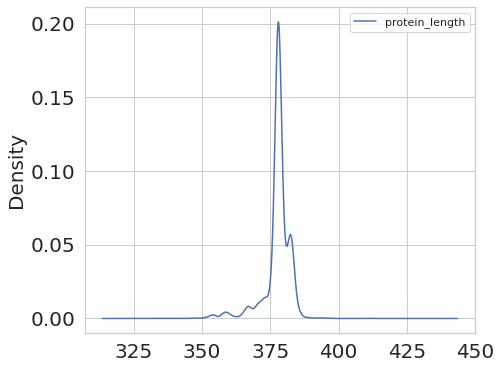

In [99]:
data_table_df.plot(kind='kde', y='protein_length', figsize=(7,6))


### Report Sequences that are too short or too long

In [5]:
#identify sequences outside of length range for analsysis
wronglength = data_table_df.loc[(data_table_df['protein_length'] < 350) | (data_table_df['protein_length'] > 390)]
wronglength

,gene_symbol,scientific_name,tax_id,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
14412034,CYTB,Polycheles typhlops,512014,NC_020026.1:13220-14404,+,chr MT,YP_007317402.1,394.0,cytochrome b
16488854,CYTB,Appalachioria falcifera,382869,NC_021933.1:13095-14279,+,chr MT,YP_008378738.1,394.0,cytochrome b
19909943,CYTB,Xenophyes cascus,984453,NC_024622.1:4092-5285,-,chr MT,YP_009049549.1,397.0,cytochrome b
22158292,CYTB,Pirata subpiraticus,330951,NC_025523.1:9589-10635,+,chr MT,YP_009104758.1,348.0,cytochrome b
22832667,CYTB,Lethe dura,1457180,NC_026062.1:10410-11585,+,chr MT,YP_009114186.1,391.0,cytochrome b
26044919,CYTB,Megachile sculpturalis,1004196,NC_028017.1:10779-12014,+,chr MT,YP_009170668.1,411.0,cytochrome b
26833526,CYTB,Heterometrus longimanus,1719223,NC_029207.1:8705-9745,+,chr MT,YP_009228517.1,346.0,cytochrome b
37543102,CYTB,Hemigrapsus penicillatus,135467,NC_038202.1:13977-15158,+,chr MT,YP_009504027.1,393.0,cytochrome b


### Remove sequences that are too short or too long           

In [6]:
## filter out sequences that are either too long or too short

min_len = 349
max_len = 391

rightlength = data_table_df.loc[(data_table_df['protein_length'] > min_len) & (data_table_df['protein_length'] < max_len)]
#rightlength.to_csv("rightlength", sep='\t')
rightlength.head()
#acclist = rightlength['protein_accession']
#rightlength.to_csv('taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', 'tax_id'])
#print(acclist)

,gene_symbol,scientific_name,tax_id,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
800081,CYTB,Triatoma dimidiata,72491,NC_002609.1:10252-11383,+,chr MT,NP_068653.1,377.0,cytochrome b
802322,CYTB,Lithobius forficatus,7552,NC_002629.1:8634-9767,+,chr MT,NP_071849.1,377.0,cytochrome b
802401,CYTB,Heterodoxus macropus,145266,NC_002651.1:4683-5783,+,chr MT,NP_073761.1,366.0,cytochrome b
802590,CYTB,Cochliomyia hominivorax,115425,NC_002660.1:11607-12743,+,chr MT,NP_075459.1,378.0,cytochrome b
802687,CYTB,Chrysomya putoria,235600,NC_002697.1:10410-11546,+,chr MT,NP_085093.1,378.0,cytochrome b


## Generate taxmap and save for later use

In [8]:
rightlength.to_csv('taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', 'tax_id'])

0

In [6]:
from Bio import SeqIO
sequences = [] 
for seq_record in SeqIO.parse("protein.faa", "fasta"): 
    s = seq_record    
    #print (seq_record.id)
    if seq_record.id in rightlength['protein_accession'].tolist():
    #if seq_record.id in acclist.tolist():
        sequences.append(s)
        #print(seq_record.id)
    else:
        print("removed accessions are: ", seq_record.id)
SeqIO.write(sequences, "stripped.fsa", "fasta")  



removed accessions are:  YP_007317402.1
removed accessions are:  YP_008378738.1
removed accessions are:  YP_009049549.1
removed accessions are:  YP_009104758.1
removed accessions are:  YP_009114186.1
removed accessions are:  YP_009170668.1
removed accessions are:  YP_009228517.1
removed accessions are:  YP_009504027.1


2867

## Run all-vs-all BLAST

In [104]:
#!scripts/blast_all.sh -b {bdbag} -a {acclist_for_blast} -t 6
os.system("makeblastdb -in stripped.fsa -parse_seqids -dbtype prot -taxid_map taxmap -out prot_blastdb")
os.system("blastp -db prot_blastdb -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")
#os.system("blast_formatter -archive blastout.asn -outfmt '7 std staxid ssciname' -out blastout.tsv")
#os.system("blastp -db nr -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")

0

## Read BLAST tsv file, remove matches to self
This creates a master file of the blast output with the organism names and taxids
NOTE NaN values in the taxid and orgname are due to inconsistencies in the data formatting from data/data_table.tsv downloaded from datasets. Need to fix this

In [7]:
file_name_string = (r'blastout.tsv')
table_df = pd.read_csv(file_name_string,
                       sep='\t',
                       index_col=None,
                       low_memory=False,
                       usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                       header=None,
                       names=["queryseqid", "subjectseqid", "identity", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "Evalue", "bitscore", "qcoverage", "taxid", "orgname"])
table_df = table_df[~table_df['queryseqid'].str.contains("#")]
table_df['%identity'] = pd.to_numeric(table_df['identity'])
table_df['length'] = pd.to_numeric(table_df['length'])
table_df['qstart'] = pd.to_numeric(table_df['qstart'])
table_df['qend'] = pd.to_numeric(table_df['qend'])
table_df['sstart'] = pd.to_numeric(table_df['sstart'])
table_df['send'] = pd.to_numeric(table_df['send'])
table_df['qcoverage'] = pd.to_numeric(table_df['qcoverage'])
#table_df
#strip .version if needed
#table_df['queryseqid'] = table_df['queryseqid'].astype(st
#table_df['queryseqid'] = table_df['queryseqid'].map(lambda x: str(x)[:-1])
table2_df = table_df.loc[(table_df['queryseqid']) != (table_df['subjectseqid'])]
table2_df.drop(['mismatch', 'gapopen', 'bitscore', '%identity'], axis=1, inplace=True)
table2_df

/home/mcveigh/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage,taxid,orgname
6,NP_068653.1,YP_009919166.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0,98665.0,Triatoma mazzottii
7,NP_068653.1,YP_009919148.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0,2086892.0,Triatoma huehuetenanguensis
8,NP_068653.1,YP_009919200.1,96.552,377.0,1.0,377.0,1.0,377.0,0.0,100.0,72494.0,Triatoma sanguisuga
9,NP_068653.1,YP_009919135.1,93.634,377.0,1.0,377.0,1.0,377.0,0.0,100.0,340914.0,Triatoma mexicana
10,NP_068653.1,YP_009412498.1,90.691,376.0,1.0,376.0,1.0,376.0,0.0,99.0,30076.0,Triatoma infestans
...,...,...,...,...,...,...,...,...,...,...,...,...
1447843,YP_009995947.1,YP_009706259.1,73.514,370.0,5.0,374.0,9.0,378.0,0.0,98.0,578476.0,Conocephalus maculatus
1447844,YP_009995947.1,YP_009563691.1,74.728,368.0,7.0,374.0,10.0,377.0,0.0,98.0,198635.0,Eristalis tenax
1447845,YP_009995947.1,YP_009561917.1,71.123,374.0,3.0,376.0,10.0,383.0,0.0,99.0,1368026.0,Clania variegata
1447846,YP_009995947.1,YP_009538076.1,72.162,370.0,7.0,376.0,13.0,382.0,0.0,98.0,398429.0,Athyma fortuna


## Create a smaller dataframe with just numberical values

In [8]:
dftidy = table2_df.drop(['taxid', 'orgname'], axis=1)
dftidy

,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage
6,NP_068653.1,YP_009919166.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0
7,NP_068653.1,YP_009919148.1,97.878,377.0,1.0,377.0,1.0,377.0,0.0,100.0
8,NP_068653.1,YP_009919200.1,96.552,377.0,1.0,377.0,1.0,377.0,0.0,100.0
9,NP_068653.1,YP_009919135.1,93.634,377.0,1.0,377.0,1.0,377.0,0.0,100.0
10,NP_068653.1,YP_009412498.1,90.691,376.0,1.0,376.0,1.0,376.0,0.0,99.0
...,...,...,...,...,...,...,...,...,...,...
1447843,YP_009995947.1,YP_009706259.1,73.514,370.0,5.0,374.0,9.0,378.0,0.0,98.0
1447844,YP_009995947.1,YP_009563691.1,74.728,368.0,7.0,374.0,10.0,377.0,0.0,98.0
1447845,YP_009995947.1,YP_009561917.1,71.123,374.0,3.0,376.0,10.0,383.0,0.0,99.0
1447846,YP_009995947.1,YP_009538076.1,72.162,370.0,7.0,376.0,13.0,382.0,0.0,98.0


## Groupby and Aggregate the top ten rows of blast results

In [17]:
table3_df = dftidy.groupby('queryseqid').head(10) 
ident_group = table3_df.groupby('queryseqid').agg(['median', 'min', 'max']) 
ident_group

identity                  length               qstart            \
              median     min      max median    min    max median  min  max   
queryseqid                                                                    
NP_006913.1  96.4285  91.005   99.735  378.0  378.0  378.0    1.0  1.0  1.0   
NP_007119.1  77.2610  72.872   92.819  376.0  373.0  376.0    6.0  6.0  9.0   
NP_007301.1  92.5930  91.293   99.208  378.0  378.0  379.0    1.0  1.0  1.0   
NP_008080.1  99.4710  98.677  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
NP_008093.1  91.3155  69.737   99.217  380.0  379.0  383.0    1.0  1.0  1.0   
...              ...     ...      ...    ...    ...    ...    ...  ...  ...   
YP_961309.1  90.2370  89.182   92.084  379.0  379.0  379.0    1.0  1.0  1.0   
YP_961393.1  99.6030  98.148  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973126.1  91.2695  90.476   98.677  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973139.1  87.5660  87.037   88.095  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973152.1  89.1530  88.889   96.032  378.0  378.0  378.0    1.0  1.0  1.0   

              qend  ... sstart   send               Evalue            \
            median  ...    max median    min    max median  min  max   
queryseqid          ...                                                
NP_006913.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_007119.1  381.0  ...    5.0  376.0  376.0  377.0    0.0  0.0  0.0   
NP_007301.1  378.0  ...    1.0  378.0  378.0  379.0    0.0  0.0  0.0   
NP_008080.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_008093.1  380.0  ...    1.0  380.0  379.0  383.0    0.0  0.0  0.0   
...            ...  ...    ...    ...    ...    ...    ...  ...  ...   
YP_961309.1  379.0  ...    1.0  379.0  379.0  379.0    0.0  0.0  0.0   
YP_961393.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973126.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973139.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973152.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   

            qcoverage                
               median    min    max  
queryseqid                           
NP_006913.1     100.0  100.0  100.0  
NP_007119.1      99.0   98.0   99.0  
NP_007301.1      99.0   99.0  100.0  
NP_008080.1     100.0  100.0  100.0  
NP_008093.1      99.0   99.0  100.0  
...               ...    ...    ...  
YP_961309.1     100.0  100.0  100.0  
YP_961393.1     100.0  100.0  100.0  
YP_973126.1     100.0  100.0  100.0  
YP_973139.1     100.0  100.0  100.0  
YP_973152.1     100.0  100.0  100.0  

[2867 rows x 24 columns]

## Convert back to one dimentional index for searborn

In [10]:
ident_group.columns = ident_group.columns.map('_'.join)
ident_group.columns.get_level_values(0)


Index(['identity_median', 'identity_min', 'identity_max', 'length_median',
       'length_min', 'length_max', 'qstart_median', 'qstart_min', 'qstart_max',
       'qend_median', 'qend_min', 'qend_max', 'sstart_median', 'sstart_min',
       'sstart_max', 'send_median', 'send_min', 'send_max', 'Evalue_median',
       'Evalue_min', 'Evalue_max', 'qcoverage_median', 'qcoverage_min',
       'qcoverage_max'],
      dtype='object')

In [11]:
ident_group

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,sstart_max,send_median,send_min,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006913.1,96.4285,91.005,99.735,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_007119.1,77.2610,72.872,92.819,376.0,373.0,376.0,6.0,6.0,9.0,381.0,...,5.0,376.0,376.0,377.0,0.0,0.0,0.0,99.0,98.0,99.0
NP_007301.1,92.5930,91.293,99.208,378.0,378.0,379.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,379.0,0.0,0.0,0.0,99.0,99.0,100.0
NP_008080.1,99.4710,98.677,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_008093.1,91.3155,69.737,99.217,380.0,379.0,383.0,1.0,1.0,1.0,380.0,...,1.0,380.0,379.0,383.0,0.0,0.0,0.0,99.0,99.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_961309.1,90.2370,89.182,92.084,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,1.0,379.0,379.0,379.0,0.0,0.0,0.0,100.0,100.0,100.0
YP_961393.1,99.6030,98.148,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
YP_973126.1,91.2695,90.476,98.677,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0


In [12]:
ident_group.to_csv(r'ident_group_file', sep ='\t', index = True)

## Let's plot the query coverage data to visual

<AxesSubplot:ylabel='Density'>

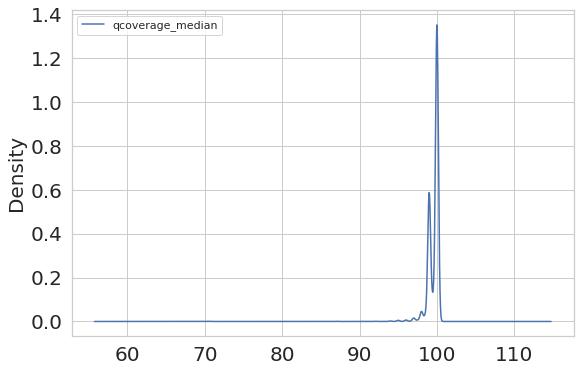

In [110]:
ident_group.plot(kind='kde', y='qcoverage_median', figsize=(9,6))
#ident_group.savefig('qcov_median.png')

## Median %identity

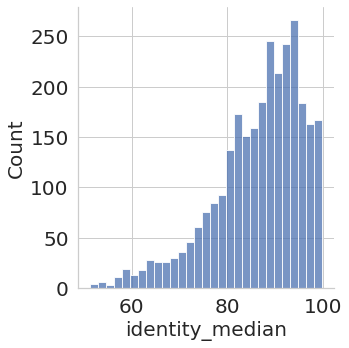

<Figure size 3600x1440 with 0 Axes>

In [111]:
sns.displot(ident_group.identity_median.dropna())
plt.show()
plt.savefig('identity_displot.png')

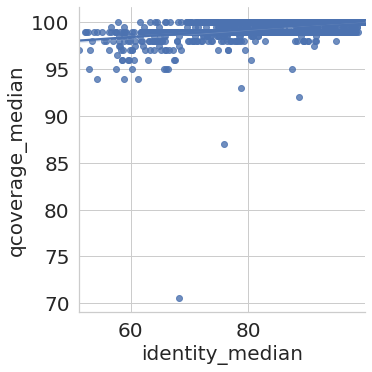

In [112]:
sns.set_style('whitegrid') 
sns.lmplot(x ='identity_median', y ='qcoverage_median', data = ident_group) 

# Examine %identity by tax group

In [13]:
orgtable = pd.read_csv(data_table, sep='\t', index_col=None, low_memory=False, usecols=[2,3,7], header=None, skiprows=1, names=["orgname", "taxid", "accession"])
#orgtable
taxid = []
for index, row in orgtable.iterrows():
    taxid = orgtable['taxid'].astype(int) 
    lineage = ncbi.get_lineage(taxid)
    print(lineage)
#Se_lineage

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [46]:
lineage_tbl = (r'acc_list_lineage')
lineage_df = pd.read_csv(lineage_tbl, sep='\t', index_col=None, low_memory=False, usecols=[0,1,2,3], header=None, skiprows=1, names=["accession", "qorgname", "taxid", "lineage"])
#lineage_df
lineage_df[['genus', 'species']] = lineage_df.qorgname.str.split(' ',1, expand=True)
lineage_df
#for index, row in table2_df.iterrows():
#    queryseqid = table2_df['queryseqid']
#    if lineage_df.loc[lineage_df['accession'] == queryseqid]
        #querytaxname = lineage_df['qorgname']
        #if querytaxname == table2_df['orgname']
            #print (querytaxname)
    
    



,accession,qorgname,taxid,lineage,genus,species
0,NP_068653.1,Triatoma dimidiata,72491,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Triatoma,dimidiata
1,NP_071849.1,Lithobius forficatus,7552,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Myr...,Lithobius,forficatus
2,NP_073761.1,Heterodoxus macropus,145266,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Heterodoxus,macropus
3,NP_075459.1,Cochliomyia hominivorax,115425,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Cochliomyia,hominivorax
4,NP_085093.1,Chrysomya putoria,235600,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Chrysomya,putoria
...,...,...,...,...,...,...
2862,YP_009995543.1,Eristalinus quinquestriatus,2807723,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Eristalinus,quinquestriatus
2863,YP_009995908.1,Pterodecta felderi,655083,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Pterodecta,felderi
2864,YP_009995921.1,Spondylis buprestoides,1395520,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Spondylis,buprestoides
2865,YP_009995934.1,Chrysolina aeruginosa,640304,Eukaryota; Metazoa; Ecdysozoa; Arthropoda; Hex...,Chrysolina,aeruginosa


In [ ]:
    
#table4_df = table2_df.groupby('queryseqid').head(11) 
#table4_df.to_csv(r'identity_stats', sep ='\t', index = True)

## Identify sequences with values below the pass/fail thresholds %identity and query coverage

In [114]:
identity_low = ident_group[ident_group['identity_max'] <72 ].index.tolist()
identity_low

['NP_071849.1',
 'NP_073761.1',
 'NP_542476.1',
 'NP_542489.1',
 'NP_758884.1',
 'YP_001218728.1',
 'YP_001552109.1',
 'YP_001552176.1',
 'YP_001648734.1',
 'YP_001837107.1',
 'YP_001936591.1',
 'YP_002213623.1',
 'YP_002242164.1',
 'YP_002317256.1',
 'YP_002317282.1',
 'YP_002735002.1',
 'YP_002889407.1',
 'YP_002907411.1',
 'YP_003204693.1',
 'YP_003288848.1',
 'YP_003433910.1',
 'YP_003540690.1',
 'YP_003587337.1',
 'YP_003891060.1',
 'YP_004021101.1',
 'YP_004841759.1',
 'YP_004842321.1',
 'YP_005087986.1',
 'YP_005353019.1',
 'YP_006234167.1',
 'YP_006576240.1',
 'YP_006665907.1',
 'YP_007026944.1',
 'YP_007474199.1',
 'YP_007474879.1',
 'YP_007474892.1',
 'YP_008378747.1',
 'YP_008963766.1',
 'YP_009002094.1',
 'YP_009019486.1',
 'YP_009020947.1',
 'YP_009027729.1',
 'YP_009073498.1',
 'YP_009092379.1',
 'YP_009093741.1',
 'YP_009104522.1',
 'YP_009104533.1',
 'YP_009114522.1',
 'YP_009121683.1',
 'YP_009122998.1',
 'YP_009126970.1',
 'YP_009127082.1',
 'YP_009128306.1',
 'YP_009

In [115]:
qcov_low = ident_group[ident_group['qcoverage_min'] < 90].index.tolist()
qcov_low 

['YP_001218728.1',
 'YP_002836178.1',
 'YP_007025136.1',
 'YP_009306447.1',
 'YP_009945379.1',
 'YP_271856.1']

## Sort fasta file creating two files [1] seqs that pass [2] seqs that fail

In [119]:
from Bio import SeqIO
sequences = [] 
fail_sequence = []
for seq_record in SeqIO.parse("stripped.fsa", "fasta"):
    s = seq_record
    if seq_record.id in identity_low:
        print("fails seq identity test", seq_record.id)
        fail_sequence.append(s)
    elif seq_record.id in qcov_low:
        fail_sequence.append(s)
        print("fails qcov test",seq_record.id)
    else:
        sequences.append(s)
        #print(seq_record.id)
        
SeqIO.write(sequences, "outputfile", "fasta")

fails seq identity test NP_071849.1
fails seq identity test NP_073761.1
fails seq identity test NP_542489.1
fails seq identity test NP_542476.1
fails seq identity test NP_758884.1
fails seq identity test YP_015447.1
fails seq identity test YP_025747.1
fails seq identity test YP_026063.1
fails seq identity test YP_026051.1
fails seq identity test YP_025734.1
fails seq identity test YP_026006.1
fails seq identity test YP_073318.1
fails seq identity test YP_086825.1
fails qcov test YP_271856.1
fails seq identity test YP_740081.1
fails seq identity test YP_784044.1
fails seq identity test YP_863647.1
fails seq identity test YP_001218728.1
fails seq identity test YP_001552109.1
fails seq identity test YP_001552176.1
fails seq identity test YP_001648734.1
fails seq identity test YP_001837107.1
fails seq identity test YP_001936591.1
fails seq identity test YP_002213623.1
fails seq identity test YP_002242164.1
fails seq identity test YP_002317282.1
fails seq identity test YP_002317256.1
fails 

2750

In [122]:
sh = open("protein.faa")
num = 0
for line in sh:
    if line.startswith(">"):
        num += 1
sh.close()
print("Number of sequences in the starting input file:", num)

Number of sequences in the starting input file: 2875


In [121]:
fh = open("outputfile")
n = 0
for line in fh:
    if line.startswith(">"):
        n += 1
fh.close()
print("Number of sequences passing all validation tests and saved to outputfile:", n)

Number of sequences passing all validation tests and saved to outputfile: 2750
